In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os

In [2]:
curr_dir = "WTB_Images_03152021"
MODEL_DIR = "../checkpoints/imagenet.h5"

In [3]:
num_skipped = 0
for folder_name in ("Bear", "Coyote", "Deer", "Other", "Empty"):
    folder_path = os.path.join(curr_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
image_size = (1920, 1080)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    curr_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    curr_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 210 files belonging to 5 classes.
Using 168 files for training.
Found 210 files belonging to 5 classes.
Using 42 files for validation.


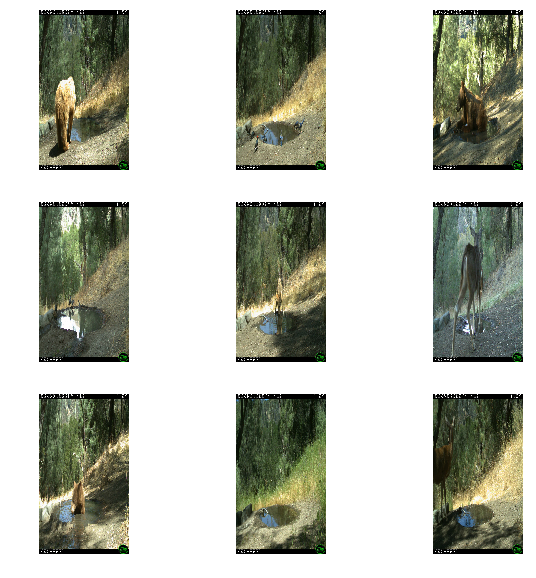

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(labels[i])
        plt.axis("off")

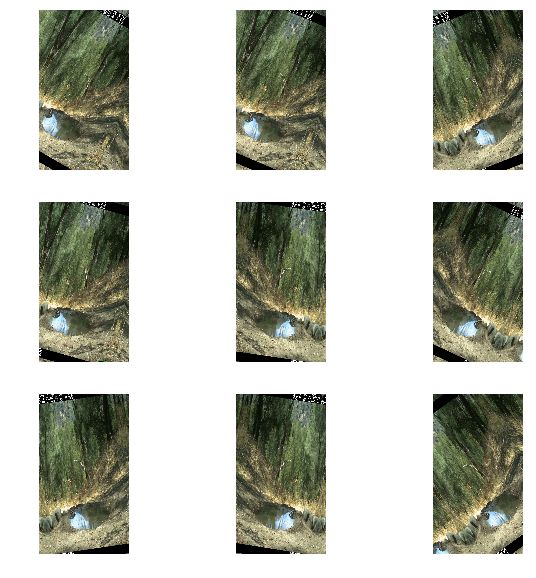

In [84]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(imaoges)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [54]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [85]:
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)

In [5]:
model = load_model(MODEL_DIR)

In [72]:
input_t = keras.Input(shape=(1920, 1080, 3))
res_model = keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=input_t)

# Lock up all layers of ResNet50 except the last block
for layer in res_model.layers[:143]:
    layer.trainable = False
    
model = keras.models.Sequential()
model.add(res_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(5, activation='softmax'))

In [6]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 60, 34, 2048)      23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 4177920)           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 4177920)           16711680  
_________________________________________________________________
dense_36 (Dense)             (None, 256)               1069547776
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 256)               1024      
_________________________________________________________________
dense_37 (Dense)             (None, 128)             

In [ ]:
epochs = 1

callbacks = [keras.callbacks.ModelCheckpoint(filepath = "save_at_{epoch}.h5",
                                             monitor = "val_acc",
                                             mode = "max",
                                             save_best_only = True),]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"],)

model.fit(train_ds, 
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=callbacks, 
          validation_data=val_ds,
          verbose=1,)
# model.save("../checkpoints/imagenet.h5")